In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
####################################################################################################

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import SchemDraw as schem

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Physics.SemiConductor import ShockleyDiode

os.environ['PySpiceLibraryPath'] = '~/Projects/ROIC/src/PySpice/examples/libraries'

####################################################################################################

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)
####################################################################################################

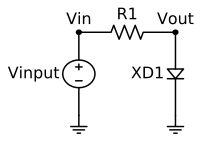

In [26]:
#r# For this purpose, we use the common high-speed diode 1N4148.  The diode is driven by a variable
#r# voltage source through a limiting current resistance.

#f# circuit_macros('diode-characteristic-curve-circuit.m4')

circuit = Circuit('Diode Characteristic Curve')

circuit.include(spice_library['1N4148'])

circuit.schematic.add(schem.elements.GND)
V =circuit.V('input', 'Vin', circuit.gnd, 10@u_V,
            schematic_kwargs={'show_plus': True}
            )
R = circuit.R('1', 'Vin', 'Vout', 1@u_Ω,
              schematic_kwargs={'d':'right', 'show_minus': True}
             ) # not required for simulation
X = circuit.X('D1', '1N4148', 'Vout', circuit.gnd,
             schematic_kwargs={'schematic': schem.elements.DIODE, 'd':'down'},
             )
circuit.schematic.add(schem.elements.GND)
circuit.schematic.draw()

In [ ]:
#pos = nx.spectral_layout(circuit.graph)
#nx.draw(circuit.graph, pos=pos, with_labels=True, node_size=1200,  node_shape='s',
#       width=2.0)
#edge_labels = nx.get_edge_attributes(circuit.graph,'name')
#nx.draw_networkx_edge_labels(circuit.graph, pos, edge_labels=edge_labels)



In [27]:
#r# We simulate the circuit at these temperatures: 0, 25 and 100 °C.

# Fixme: Xyce ???
temperatures = [0, 25, 100]@u_Degree
analyses = {}
for temperature in temperatures:
    simulator = circuit.simulator(temperature=temperature, nominal_temperature=temperature)
    analysis = simulator.dc(Vinput=slice(-2, 5, .01))
    analyses[float(temperature)] = analysis

####################################################################################################

Text(1,-100,'Forward Biased Region')

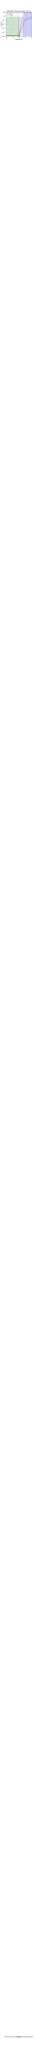

In [22]:
#r# We plot the characteristic curve and compare it to the Shockley diode model:
#r#
#r# .. math::
#r#
#r#     I_d = I_s \left( e^{\frac{V_d}{n V_T}} - 1 \right)
#r#
#r# where :math:`V_T = \frac{k T}{q}`
#r#
#r# In order to scale the reverse biased region, we have to do some hack with Matplotlib.
#r#

silicon_forward_voltage_threshold = .7

shockley_diode = ShockleyDiode(Is=4.0@u_nA, degree=25)

def two_scales_tick_formatter(value, position):
    if value >= 0:
        return '{} mA'.format(value)
    else:
        return '{} nA'.format(value/100)
formatter = ticker.FuncFormatter(two_scales_tick_formatter)

figure = plt.figure(1, (10, 5))

axe = plt.subplot(121)
axe.set_title('1N4148 Characteristic Curve ')
axe.set_xlabel('Voltage [V]')
axe.set_ylabel('Current')
axe.grid()
axe.set_xlim(-2, 2)
axe.axvspan(-2, 0, facecolor='green', alpha=.2)
axe.axvspan(0, silicon_forward_voltage_threshold, facecolor='blue', alpha=.1)
axe.axvspan(silicon_forward_voltage_threshold, 2, facecolor='blue', alpha=.2)
#axe.set_ylim(-500, 750) # Fixme: round
#axe.yaxis.set_major_formatter(formatter)
Vd = analyses[25].Vout
# compute scale for reverse and forward region
forward_region = Vd >= 0@u_V
reverse_region = np.invert(forward_region)
scale =  reverse_region*1e11 + forward_region*1e3
#?# check temperature
for temperature in temperatures:
    analysis = analyses[float(temperature)]
    axe.plot(Vd, np.abs(- analysis.Vinput))
axe.plot(Vd, np.abs(shockley_diode.I(Vd)), 'black')
axe.set_ylim(1e-9, 1e3)
axe.set_yscale('log')
axe.legend(['@ {}'.format(temperature)
            for temperature in temperatures] + ['Shockley Diode Model Is = 4 nA'],
           loc=2, fontsize=10)
axe.axvline(x=0, color='black')
axe.axhline(y=0, color='black')
axe.axvline(x=silicon_forward_voltage_threshold, color='red')
axe.text(-1, -100, 'Reverse Biased Region', ha='center', va='center')
axe.text( 1, -100, 'Forward Biased Region', ha='center', va='center')